In [1]:
!pip install tensorflow tensorflowjs keras opendatasets pandas numpy matplotlib Pillow scipy scikit-learn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 660.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Standard libraries
import os
from collections import defaultdict

import random
import shutil
import pathlib
import zipfile

# Image processing
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data processing
import pandas as pd
import numpy as np
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2
from tensorflow.keras.regularizers import l2

# External tools
import opendatasets as od

In [3]:
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.18.0


In [4]:
# Unggah kaggle.json terlebih dahulu
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mc189d5y0468","key":"714bc552a06e731c3cc4ecd865cd3254"}'}

In [5]:
# Setup Kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download PlantVillage Dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0


In [6]:
# Ekstrak file
!unzip -q plantvillage-dataset.zip -d plantvillage_dataset

In [8]:
!ls -R /content/plantvillage_dataset

Streaming output truncated to the last 5000 lines.
'11030437-942c-4cb4-a40e-b35236778a4b___UF.GRC_YLCV_Lab 02923_final_masked.jpg'
'1104914f-f715-4b02-b551-5cdf03f54bcb___YLCV_NREC 2717_final_masked.jpg'
'11061195-ce9c-4171-819d-663342a186e8___YLCV_NREC 0257_final_masked.jpg'
'110c50e6-039e-4f32-bda1-26262968ab8a___YLCV_GCREC 5539_final_masked.jpg'
'1114e83e-5477-483c-8bed-847b2c169c9f___YLCV_NREC 2257_final_masked.jpg'
'111d4096-e9eb-4f32-9a25-f3c19b92c627___YLCV_GCREC 2209_final_masked.jpg'
'1126f296-0c84-4f9d-b66b-1e9a91794ec9___UF.GRC_YLCV_Lab 09340_final_masked.jpg'
'112779d4-27f3-4c5e-8813-b64d26ef7e03___UF.GRC_YLCV_Lab 02860_final_masked.jpg'
'11310b42-2463-4a9c-bc4e-145f73bee307___YLCV_GCREC 2609_final_masked.jpg'
'114aede5-a632-4623-8c0e-5517a4a207e7___YLCV_GCREC 2702_final_masked.jpg'
'11565eea-c48c-4727-b880-7c9a76fb3e35___UF.GRC_YLCV_Lab 01799_final_masked.jpg'
'115c36f2-2c97-4a9a-a091-3c6e976a5e79___UF.GRC_YLCV_Lab 01829_final_masked.jpg'
'11796227-f10e-4502-a849-ddff117a0

In [9]:
def resize_images_in_directory(base_path, min_size=200, max_size=256):
    for root, _, files in os.walk(base_path):
        for filename in files:
            path = os.path.join(root, filename)
            try:
                with Image.open(path) as img:
                    new_size = (
                        random.randint(min_size, max_size),
                        random.randint(min_size, max_size)
                    )
                    resized = img.resize(new_size, Image.Resampling.LANCZOS)
                    resized.save(path)
            except Exception as err:
                print(f"Gagal memproses {path}: {err}")


def analyze_dataset(base_path, target_res=None):
    class_counts = {}
    resolution_counts = {}

    for root, _, files in os.walk(base_path):
        if not files:
            continue

        class_name = os.path.basename(root)
        class_counts[class_name] = len(files)

        for filename in files:
            path = os.path.join(root, filename)
            try:
                with Image.open(path) as img:
                    res = f"{img.width}x{img.height}"
                    resolution_counts[res] = resolution_counts.get(res, 0) + 1

                    if target_res and res == target_res:
                        resolution_counts['target'] = resolution_counts.get('target', 0) + 1
            except Exception as err:
                print(f"Error membaca {path}: {err}")

    return class_counts, resolution_counts


def display_analysis(class_counts, resolution_counts):

    print("\n Jumlah Gambar per Kelas:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")


dataset_path = '/content/plantvillage_dataset/plantvillage dataset/color'

target_res = "256x256"

# Langkah 1: Resize semua gambar
resize_images_in_directory(dataset_path, min_size=200, max_size=256)

# Langkah 2: Analisis dataset setelah resize
class_counts, resolution_counts = analyze_dataset(dataset_path, target_res)

# Langkah 3: Tampilkan hasil analisis
display_analysis(class_counts, resolution_counts)


 Jumlah Gambar per Kelas:
  Corn_(maize)___healthy: 1162
  Cherry_(including_sour)___healthy: 854
  Pepper,_bell___Bacterial_spot: 997
  Corn_(maize)___Common_rust_: 1192
  Peach___healthy: 360
  Tomato___Spider_mites Two-spotted_spider_mite: 1676
  Apple___Black_rot: 621
  Strawberry___healthy: 456
  Orange___Haunglongbing_(Citrus_greening): 5507
  Grape___Esca_(Black_Measles): 1383
  Strawberry___Leaf_scorch: 1109
  Tomato___Bacterial_spot: 2127
  Tomato___Tomato_mosaic_virus: 373
  Grape___Black_rot: 1180
  Squash___Powdery_mildew: 1835
  Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076
  Tomato___Leaf_Mold: 952
  Tomato___Early_blight: 1000
  Potato___Late_blight: 1000
  Apple___Cedar_apple_rust: 275
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513
  Corn_(maize)___Northern_Leaf_Blight: 985
  Grape___healthy: 423
  Tomato___Target_Spot: 1404
  Tomato___Late_blight: 1909
  Apple___healthy: 1645
  Tomato___Tomato_Yellow_Leaf_Curl_Virus: 5357
  Blueberry___healthy: 1502
  Pe

In [10]:
def salin_folder_keyword(sumber, tujuan="dataset", keyword="tomato"):

    os.makedirs(tujuan, exist_ok=True)

    for root, dirs, _ in os.walk(sumber):
        for nama_folder in dirs:
            if keyword.lower() in nama_folder.lower():
                asal = os.path.join(root, nama_folder)
                tujuan_salin = os.path.join(tujuan, nama_folder)

                if not os.path.exists(tujuan_salin):
                    shutil.copytree(asal, tujuan_salin)
                    print(f"✅ Disalin: {asal} → {tujuan_salin}")
                else:
                    print(f"⚠️ Dilewati (sudah ada): {tujuan_salin}")

def rapikan_nama_folder(direktori, hapus_prefix="Tomato___"):

    for nama in os.listdir(direktori):
        if nama.startswith(hapus_prefix):
            asal = os.path.join(direktori, nama)
            baru = os.path.join(direktori, nama[len(hapus_prefix):])
            os.rename(asal, baru)
            print(f"✏️ Diubah: {asal} → {baru}")

# Jalankan proses
if __name__ == "__main__":
    sumber_dataset = '/content/plantvillage_dataset/plantvillage dataset/color'
    folder_tujuan = '/content/tomato_dataset'  # Target folder di content langsung

    salin_folder_keyword(sumber_dataset, folder_tujuan, keyword="tomato")
    rapikan_nama_folder(folder_tujuan, hapus_prefix="Tomato___")


✅ Disalin: /content/plantvillage_dataset/plantvillage dataset/color/Tomato___Spider_mites Two-spotted_spider_mite → /content/tomato_dataset/Tomato___Spider_mites Two-spotted_spider_mite
✅ Disalin: /content/plantvillage_dataset/plantvillage dataset/color/Tomato___Bacterial_spot → /content/tomato_dataset/Tomato___Bacterial_spot
✅ Disalin: /content/plantvillage_dataset/plantvillage dataset/color/Tomato___Tomato_mosaic_virus → /content/tomato_dataset/Tomato___Tomato_mosaic_virus
✅ Disalin: /content/plantvillage_dataset/plantvillage dataset/color/Tomato___Leaf_Mold → /content/tomato_dataset/Tomato___Leaf_Mold
✅ Disalin: /content/plantvillage_dataset/plantvillage dataset/color/Tomato___Early_blight → /content/tomato_dataset/Tomato___Early_blight
✅ Disalin: /content/plantvillage_dataset/plantvillage dataset/color/Tomato___Target_Spot → /content/tomato_dataset/Tomato___Target_Spot
✅ Disalin: /content/plantvillage_dataset/plantvillage dataset/color/Tomato___Late_blight → /content/tomato_dataset

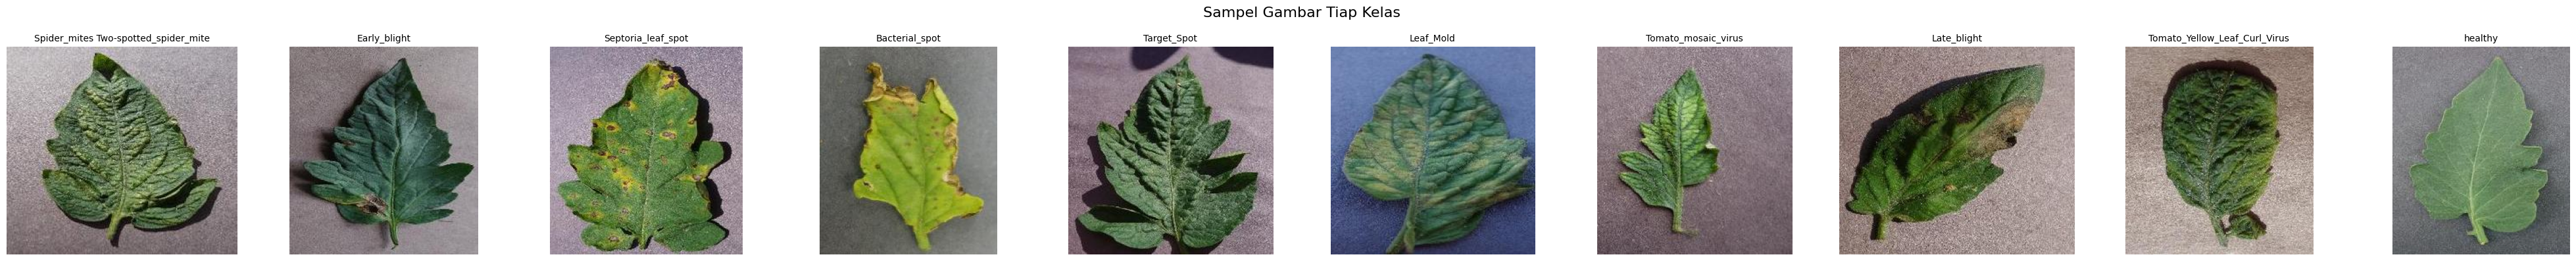

In [11]:
def show_example_image(dataset_path):
    gambar_kelas = {}

    # Telusuri setiap subfolder untuk mengambil satu gambar acak
    for folder_utama, _, daftar_berkas in os.walk(dataset_path):
        if daftar_berkas:
            nama_kelas = os.path.basename(folder_utama)
            contoh = random.choice(daftar_berkas)
            gambar_kelas[nama_kelas] = os.path.join(folder_utama, contoh)

    jumlah_kelas = len(gambar_kelas)
    ukuran_fig = (4 * jumlah_kelas, 4)
    fig, axes = plt.subplots(1, jumlah_kelas, figsize=ukuran_fig)
    fig.suptitle("Sampel Gambar Tiap Kelas", fontsize=16)

    if jumlah_kelas == 1:
        axes = [axes]

    for ax, (label, path) in zip(axes, gambar_kelas.items()):
        with Image.open(path) as img:
            ax.imshow(img)
        ax.set_title(label, fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Panggil fungsi langsung
show_example_image("/content/tomato_dataset")

In [12]:
def delete_unwanted_folders(base_path, keep_folders=None):

    if keep_folders is None:
        keep_folders = ['Tomato_Yellow_Leaf_Curl_Virus', 'Late_blight', 'healthy', 'Septoria_leaf_spot']

    # Menelusuri setiap item di dalam base_path
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)

        # Mengecek jika item adalah folder dan bukan folder yang ingin dipertahankan
        if os.path.isdir(item_path) and item not in keep_folders:
            shutil.rmtree(item_path)  # Menghapus folder
            print(f"Menghapus folder: {item_path}")

# Path ke folder utama
base_path = "/content/tomato_dataset"

# Menjalankan fungsi untuk menghapus folder yang tidak diinginkan
delete_unwanted_folders(base_path)

Menghapus folder: /content/tomato_dataset/Spider_mites Two-spotted_spider_mite
Menghapus folder: /content/tomato_dataset/Early_blight
Menghapus folder: /content/tomato_dataset/Bacterial_spot
Menghapus folder: /content/tomato_dataset/Target_Spot
Menghapus folder: /content/tomato_dataset/Leaf_Mold
Menghapus folder: /content/tomato_dataset/Tomato_mosaic_virus


In [13]:
def split_dataset(base_path, train_ratio=0.8):
    train_path = os.path.join(base_path, 'train')
    test_path = os.path.join(base_path, 'test')

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    for root, dirs, files in os.walk(base_path):
        if root == base_path or os.path.basename(root) in ['train', 'test']:
            continue

        class_name = os.path.basename(root)
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        random.shuffle(files)
        split_index = int(train_ratio * len(files))
        train_files = files[:split_index]
        test_files = files[split_index:]

        for file in train_files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(train_class_path, file)
            shutil.move(src_file, dst_file)

        for file in test_files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(test_class_path, file)
            shutil.move(src_file, dst_file)

# Set path ke dataset utama
base_path = "/content/tomato_dataset"

# Bagi dataset menjadi train/test
split_dataset(base_path)


def delete_unwanted_folders(base_path, keep_folders=['train', 'test']):
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and item not in keep_folders:
            shutil.rmtree(item_path)
            print(f"Menghapus folder: {item_path}")

# Path ke folder utama
base_path = "/content/tomato_dataset"

delete_unwanted_folders(base_path)

Menghapus folder: /content/tomato_dataset/Septoria_leaf_spot
Menghapus folder: /content/tomato_dataset/Late_blight
Menghapus folder: /content/tomato_dataset/Tomato_Yellow_Leaf_Curl_Virus
Menghapus folder: /content/tomato_dataset/healthy


In [14]:
def augmentasi_dan_resize_dataset(path_dataset, ukuran_gambar=(150, 150), batch_size=32):
    path_train = os.path.join(path_dataset, 'train')
    path_test = os.path.join(path_dataset, 'test')

    # Generator dengan augmentasi untuk data pelatihan
    augmentasi_train = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2  # Membagi sebagian data training untuk validasi
    )

    # Generator untuk data testing tanpa augmentasi
    augmentasi_test = ImageDataGenerator(rescale=1./255)

    # Buat generator untuk data pelatihan
    generator_train = augmentasi_train.flow_from_directory(
        path_train,
        target_size=ukuran_gambar,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    # Buat generator untuk data validasi
    generator_validasi = augmentasi_train.flow_from_directory(
        path_train,
        target_size=ukuran_gambar,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    # Buat generator untuk data pengujian
    generator_test = augmentasi_test.flow_from_directory(
        path_test,
        target_size=ukuran_gambar,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return generator_train, generator_validasi, generator_test

# Path ke dataset utama
path_dataset = "/content/tomato_dataset"

# Jalankan augmentasi serta pembagian train, validasi, dan test
generator_train, generator_validasi, generator_test = augmentasi_dan_resize_dataset(path_dataset)


Found 6756 images belonging to 4 classes.
Found 1688 images belonging to 4 classes.
Found 2184 images belonging to 4 classes.


In [15]:
# Mendapatkan dan menampilkan indeks kelas dari train_generator
class_indices = generator_train.class_indices
print(class_indices)

{'Late_blight': 0, 'Septoria_leaf_spot': 1, 'Tomato_Yellow_Leaf_Curl_Virus': 2, 'healthy': 3}


In [18]:
def buat_dan_latih_model(generator_train, generator_val, jumlah_epoch=10):
    # Menggunakan MobileNetV2 sebagai model pralatih tanpa fully connected layer di atasnya
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

    # Membekukan semua layer di model pralatih agar tidak ikut dilatih
    for layer in base_model.layers:
        layer.trainable = False

    # Membangun model baru dengan struktur Sequential
    model = Sequential([
        base_model,  # Tambahkan model pralatih
        Conv2D(32, (3, 3), activation='relu', padding='same'),  # Konvolusi pertama
        MaxPooling2D((2, 2)),  # Pooling pertama
        Conv2D(64, (3, 3), activation='relu', padding='same'),  # Konvolusi kedua
        MaxPooling2D((2, 2)),  # Pooling kedua
        Flatten(name="flatten"),  # Meratakan output
        Dropout(0.5),  # Dropout untuk mengurangi overfitting
        Dense(128, activation="relu"),  # Dense layer
        Dense(generator_train.num_classes, activation='softmax')  # Output layer softmax
    ])

    # Kompilasi model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),  # Optimizer Adam
        loss='categorical_crossentropy',       # Loss untuk klasifikasi banyak kelas
        metrics=['accuracy']                   # Metrik akurasi
    )

    # Menyimpan model terbaik otomatis saat validasi loss membaik
    simpan_model = ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )

    # Menghentikan pelatihan dini jika validasi akurasi tidak meningkat
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        mode='max'
    )

    # Proses pelatihan model
    history = model.fit(
        generator_train,
        validation_data=generator_val,
        epochs=jumlah_epoch,
        callbacks=[simpan_model, early_stop],
        verbose=1
    )

    return model, history

# Asumsikan generator_train dan generator_val sudah tersedia
model, history = buat_dan_latih_model(generator_train, generator_validasi, jumlah_epoch=10)

<ipython-input-18-1c09d6968ab4>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 115s 523ms/step - accuracy: 0.8069 - loss: 0.5215 - val_accuracy: 0.9212 - val_loss: 0.2088
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 132s 617ms/step - accuracy: 0.9488 - loss: 0.1451 - val_accuracy: 0.9692 - val_loss: 0.0903
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 108s 509ms/step - accuracy: 0.9623 - loss: 0.1171 - val_accuracy: 0.9698 - val_loss: 0.0900
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 110s 520ms/step - accuracy: 0.9747 - loss: 0.0771 - val_accuracy: 0.9568 - val_loss: 0.1448
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 106s 501ms/step - accuracy: 0.9787 - loss: 0.0768 - val_accuracy: 0.9704 - val_loss: 0.0843
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 108s 509ms/step - accuracy: 0.9808 - loss: 0.0636 - val_accuracy: 0.9745 - val_loss: 0.0813
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 111s 525ms/step - accuracy: 0.9797 - loss: 0.0684 - val_accuracy: 0.9757 - val_loss: 0.0837
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 107s 506ms/step - accuracy: 0.9859 -

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,445,998 (13.15 MB)

 Trainable params: 396,004 (1.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 792,010 (3.02 MB)

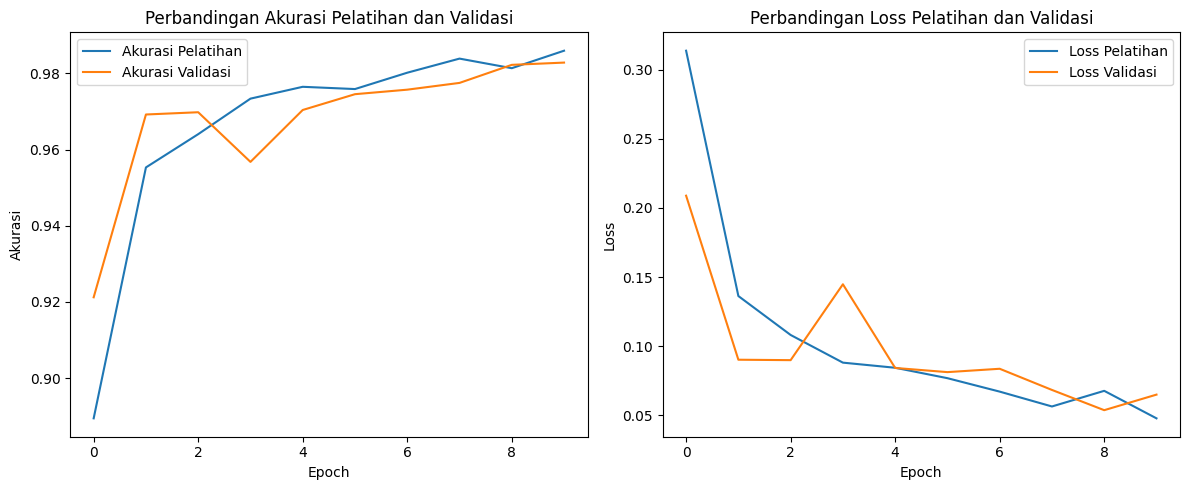

In [20]:
# Membuat plot untuk memvisualisasikan akurasi dan loss selama pelatihan
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Perbandingan Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Perbandingan Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
# Prediksi terhadap test set
predictions = model.predict(generator_test)
predicted_classes = np.argmax(predictions, axis=1)

# Label asli dari test set
true_classes = generator_test.classes
class_labels = list(generator_test.class_indices.keys())

# Evaluasi model di test set
test_loss, test_acc = model.evaluate(generator_test, verbose=0)

# Ambil akurasi terakhir dari training dan validasi dari objek history
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

# Tampilkan hasil
print(f"Akurasi Training  : {train_acc:.4f}")
print(f"Akurasi Validasi  : {val_acc:.4f}")
print(f"Akurasi Testing   : {test_acc:.4f}\n")

69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 322ms/step
Akurasi Training  : 0.9859
Akurasi Validasi  : 0.9828
Akurasi Testing   : 0.9821



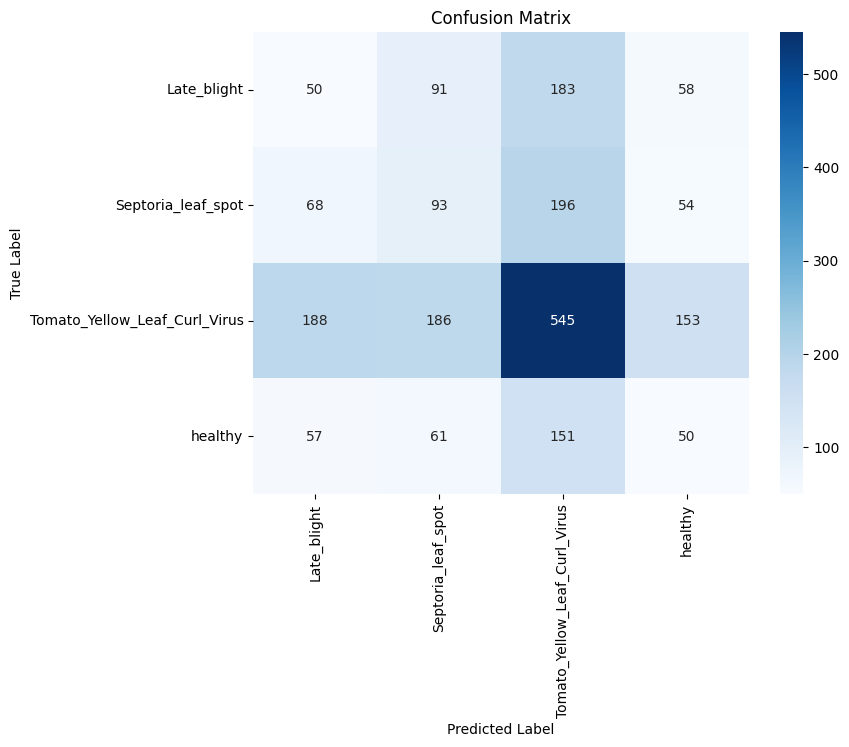

In [38]:
# Hitung confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
model.save("model.h5")

In [28]:
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-26 08:05:04.593084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745654704.623932   15815 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745654704.634567   15815 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [40]:
# Membuat direktori untuk menyimpan model dan label jika belum tersedia
save_dir = "./saved_tflite_model"
os.makedirs(save_dir, exist_ok=True)

# Memuat model dari file .h5
loaded_model = tf.keras.models.load_model('model.h5')

# Mengonversi model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_converted_model = converter.convert()

# Menyimpan file model TensorFlow Lite
tflite_model_path = os.path.join(save_dir, "model_converted.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_converted_model)

# Membuat file label untuk klasifikasi
labels = """Late_blight
Septoria_leaf_spot
Tomato_Yellow_Leaf_Curl_Virus
Healthy"""

labels_file_path = os.path.join(save_dir, "labels.txt")
with open(labels_file_path, "w") as f:
    f.write(labels)

print(f"Model TFLite dan file label telah disimpan di: {save_dir}")


Saved artifact at '/tmp/tmpl7o01sag'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138919991724368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138919991725712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138919991726096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138919991725904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138919991724560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138919991727248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138919991727824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138919991728208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138919991728016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138919991725136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389199917291

In [46]:
model.export('saved_model/my_model')

Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138920297927248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138920297928400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138920297928784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138920297928016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138920297926672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138920297928592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138920297928208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138920297925136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138920297929360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138920297925520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138920

Model membutuhkan input dengan shape: [  1 150 150   3]

Silakan upload gambar daun tomat...


Saving 02affd71-1fe6-48f7-bef4-3d5a59ec7814___UF.GRC_YLCV_Lab 01517.JPG to 02affd71-1fe6-48f7-bef4-3d5a59ec7814___UF.GRC_YLCV_Lab 01517.JPG

Memproses gambar: 02affd71-1fe6-48f7-bef4-3d5a59ec7814___UF.GRC_YLCV_Lab 01517.JPG


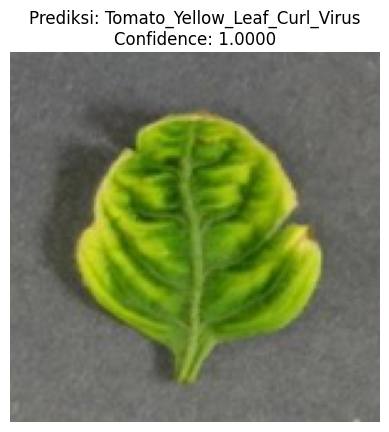

Ketik 'lanjut' untuk upload gambar lagi, atau tekan tombol lain untuk keluar: lanjut

Silakan upload gambar daun tomat...


Saving 008ebb44-eb77-4843-b621-4b88b5df7d43___RS_Late.B 5188.JPG to 008ebb44-eb77-4843-b621-4b88b5df7d43___RS_Late.B 5188.JPG

Memproses gambar: 008ebb44-eb77-4843-b621-4b88b5df7d43___RS_Late.B 5188.JPG


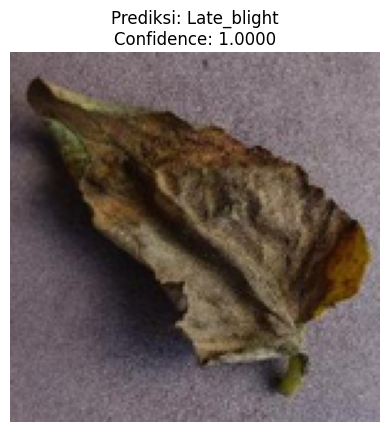

Ketik 'lanjut' untuk upload gambar lagi, atau tekan tombol lain untuk keluar: lanjut

Silakan upload gambar daun tomat...


Saving 050e7bff-2f2d-4c92-9422-05ce93f1d5a9___RS_HL 0097.JPG to 050e7bff-2f2d-4c92-9422-05ce93f1d5a9___RS_HL 0097.JPG

Memproses gambar: 050e7bff-2f2d-4c92-9422-05ce93f1d5a9___RS_HL 0097.JPG


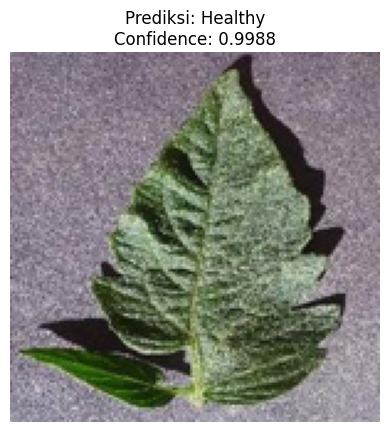

Ketik 'lanjut' untuk upload gambar lagi, atau tekan tombol lain untuk keluar: selesai
Prediksi selesai.


In [50]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import os

# Load model TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path="./saved_tflite_model/model_converted.tflite")

interpreter.allocate_tensors()

# Ambil detail input dan output dari model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model membutuhkan input dengan shape:", input_details[0]['shape'])

# Load label kelas
with open("./saved_tflite_model/labels.txt", "r") as file:
    class_labels = [line.strip() for line in file.readlines()]

# Fungsi untuk preprocessing gambar
def preprocess_image(image_path, target_size=(150, 150)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    image_array = np.array(image, dtype=np.float32) / 255.0  # Normalisasi ke [0,1]
    image_array = np.expand_dims(image_array, axis=0)  # Tambahkan batch dimension
    return image_array, image

# Fungsi untuk melakukan prediksi
def predict_image(image_path):
    input_data, original_img = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_index = np.argmax(output_data)
    predicted_label = class_labels[predicted_index]
    confidence = float(np.max(output_data))

    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_label}\nConfidence: {confidence:.4f}", fontsize=12)
    plt.show()

# Loop untuk upload dan prediksi banyak gambar
while True:
    print("\nSilakan upload gambar daun tomat...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\nMemproses gambar: {filename}")
        predict_image(filename)

    lanjut = input("Ketik 'lanjut' untuk upload gambar lagi, atau tekan tombol lain untuk keluar: ").lower()
    if lanjut != 'lanjut':
        print("Prediksi selesai.")
        break


In [51]:
!pip freeze > requirements.txt